In [12]:
import pandas as pd
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

In [26]:

ip = str(json.load(open('/home/onos/Downloads/flask_SDN/Flask-SDN/config.json'))['ip_local'])
file_name = 'lstm'+str(ip).split('.')[-1]
dataframe = pd.read_csv('/home/onos/Desktop/' + file_name + '.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/home/onos/Desktop/lstm200.csv'

# Tiền Xử Lý

In [16]:
dataframe.drop(['src', 'dst'], axis=1, inplace=True)

# Xu ly mat can bang

In [17]:
from sklearn.utils import resample
# Separate majority and minority classes
df_minority = dataframe[dataframe['label'] ==1]
df_majority = dataframe[dataframe['label'] ==0]
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples= 35000)

#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples= 35000)

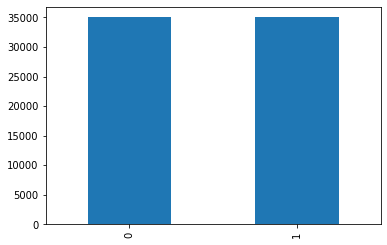

In [18]:
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_up_down_sampled['label'].value_counts().plot(kind='bar')

# Min Max scaler

In [19]:
y = df_up_down_sampled['label']
X = df_up_down_sampled.drop(columns='label')
y_set = y.values
X_set = X.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_set = scaler.fit_transform(X_set)


In [20]:
# import sklearn.external.joblib as extjoblib
import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [21]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_X, test_X, train_y, test_y = train_test_split(X_set, y_set, test_size = 0.3)


# build model

In [22]:
# Thay đổi shape của tập X
time_steps = 1
input_train_lstm = train_X.reshape( train_X.shape[0], time_steps, train_X.shape[1] )

input_test_lstm = test_X.reshape(   test_X.shape[0], time_steps, test_X.shape[1])


In [23]:
from keras import activations
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=64, input_shape=(time_steps, input_train_lstm.shape[2]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

lstm.add(LSTM(units=64, activation='relu', return_sequences=False))

# lop dau vao hinh tron
lstm.add(Dense(1)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
lstm.summary()
file_name = file_name + ".hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='accuracy', save_best_only=True, mode='auto', period=1, verbose=1)
# early = EarlyStopping(monitor='accuracy')
epoch=100
history = lstm.fit(input_train_lstm,
                   train_y,
                   epochs=epoch,
                   verbose=1,
                   callbacks=[checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 64)             17664     
                                                                 
 lstm_4 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 165,953
Trainable params: 165,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1527/1532 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.8240
Epoch 1: accuracy improved from -inf to 0.82435, saving model to best_model_lstm_